# Goal
The ultimate goal is to overfit the model on a small dstm3 dataset. If it can not be done, then something must be wrong be the model.

# Different baseline values, evolving 15 time steps, predict the sequence from t $\in$ {5, 6, 7, 8}
We initialize the sequence at different baseline values and let it evolve 4 time steps, then predict the next 4 time steps.

## Baseline value changes for every training sample
This is considered to be difficult to train the only way to fit well on this dataset is to fully capture the spatial temporal structure.

### Train and validate the model

In [12]:
import sys
# insert at 1, 0 is the script path (or ‘’ in REPL)
sys.path.insert(1, '../')
import numpy as np
import torch
from torch.utils.data import DataLoader
from bayesian_neural_net import CLSTM_cell
from bayesian_neural_net import ConvCell
from bayesian_neural_net import Encoder_pro
from bayesian_neural_net import Decoder_pro
from bayesian_neural_net import ED_pro
from bayesian_neural_net import ConvRelu
from bayesian_neural_net import DeconvRelu
from visualization import plot_spatio_temporal_data
from simulation_dataset import DatasetDstm
from simulation_dataset import DatasetDstmDecoderWithoutInput
from simulation_dataset import DatasetDstmEncoderWithoutInput
from simulation_dataset import DatasetDstm3
from simulation_dataset_datamodule import DatasetDataModule
from trainer import LightningED
from visualization import plot_spatio_temporal_data
import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger
# simulate the data
n = 10
T = 15
theta1 = 0.5
theta2 = 1
theta3 = 1
theta4 = 1
total = 200
mask = np.ones([total, T]) * np.array([1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1]) == 1
baseline_underlying = np.random.randn(total, n**2)  # the baseline changes for every sample
data = DatasetDstm3(n, T, theta1, theta2, theta3, theta4, total, mask, baseline_underlying)
data_module = DatasetDataModule(data, 1, 0.5)


# build the model
# encoder pro
rnns = [CLSTM_cell(shape=(10, 10), input_channels=16, filter_size=3, num_features=64,
                   dropout_rate=0),
        CLSTM_cell(shape=(5, 5), input_channels=64, filter_size=5, num_features=96, dropout_rate=0)
        ]

convrelus = [ConvRelu(1, 16, 3, 1, 1, dropout_rate=0.),
             ConvRelu(64, 64, 3, 2, 1, dropout_rate=0.)
             ]

encoder_net = Encoder_pro(rnns, convrelus)

# input for encoder
S = 10
B = 2
input_channels = 1
H = 64
W = 64
input_for_encoder = [torch.randn(B, S, input_channels, H, W)]

# decoder_pro
rnns = [CLSTM_cell(shape=(5, 5), input_channels=1, filter_size=3, num_features=96, dropout_rate=0),
        CLSTM_cell(shape=(10, 10), input_channels=64, filter_size=3, num_features=64, dropout_rate=0)
        ]

deconvrelus = [DeconvRelu(96, 64, 2, 2, 0, dropout_rate=0),
               DeconvRelu(64, 64, 3, 1, 1, dropout_rate=0)
               ]


cnn = ConvCell(in_channels=64, out_channels=1, kernel_size=1, stride=1, padding=0)
decoder_net = Decoder_pro(rnns, deconvrelus, cnn)

# ED net
ED_net = ED_pro(encoder_net, decoder_net)
mc_dropout = 5
learning_rate = 1e-4
max_epoch = 20
model = LightningED(ED_net, mc_dropout, learning_rate)

# load from checkpoint
try:
    model.load_from_checkpoint(checkpoint_path='dstm3_pro.ckpt', ED=ED_net, mc_dropout=mc_dropout, learning_rate=learning_rate)
except:
    print("fail to load the model")
    pass

#logger = TensorBoardLogger('tb_logs', name='Bayesian_ConvLSTM')

if torch.cuda.is_available():
    trainer = pl.Trainer(max_epochs=max_epoch, gpus=1)
else:
    trainer = pl.Trainer(max_epochs=max_epoch)
trainer.fit(model, data_module)

# save the checkpoint
trainer.save_checkpoint("dstm3_pro.ckpt")

max eigen value is 0.204281
valid initial parameters!


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type    | Params
------------------------------------------
0 | ED            | ED_pro  | 2.5 M 
1 | loss_function | MSELoss | 0     
------------------------------------------
2.5 M     Trainable params
0         Non-trainable params
2.5 M     Total params
9.812     Total estimated model params size (MB)


based on the error term, the best mse we can achieve will be above 0.0001
GroupNorm will be applied!
GroupNorm will be applied!
GroupNorm will be applied!
GroupNorm will be applied!


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

### Test on new test data

In [15]:
# test on new data
from torch import nn
n = 10
T = 15
theta1 = 0.5
theta2 = 1
theta3 = 1
theta4 = 1
total = 50  # number of test data points
mask = np.ones([total, T]) * np.array([1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1]) == 1
baseline_underlying = np.random.randn(total, n**2)
test_data = DatasetDstm3(n, T, theta1, theta2, theta3, theta4, total, mask, baseline_underlying)
test_data_loader = DataLoader(test_data, 1)  # batch size = 1
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


# load model from checkpoint
# build the model
# encoder pro
rnns = [CLSTM_cell(shape=(10, 10), input_channels=16, filter_size=3, num_features=64,
                   dropout_rate=0),
        CLSTM_cell(shape=(5, 5), input_channels=64, filter_size=5, num_features=96, dropout_rate=0)
        ]

convrelus = [ConvRelu(1, 16, 3, 1, 1, dropout_rate=0.),
             ConvRelu(64, 64, 3, 2, 1, dropout_rate=0.)
             ]

encoder_net = Encoder_pro(rnns, convrelus)

# input for encoder
S = 10
B = 2
input_channels = 1
H = 64
W = 64
input_for_encoder = [torch.randn(B, S, input_channels, H, W)]

# decoder_pro
rnns = [CLSTM_cell(shape=(5, 5), input_channels=1, filter_size=3, num_features=96, dropout_rate=0),
        CLSTM_cell(shape=(10, 10), input_channels=64, filter_size=3, num_features=64, dropout_rate=0)
        ]

deconvrelus = [DeconvRelu(96, 64, 2, 2, 0, dropout_rate=0),
               DeconvRelu(64, 64, 3, 1, 1, dropout_rate=0)
               ]


cnn = ConvCell(in_channels=64, out_channels=1, kernel_size=1, stride=1, padding=0)
decoder_net = Decoder_pro(rnns, deconvrelus, cnn)

# ED net
ED_net = ED_pro(encoder_net, decoder_net)
mc_dropout = 5
learning_rate = 1e-4
max_epoch = 20
model = LightningED(ED_net, mc_dropout, learning_rate)

# load from checkpoint
try:
    model.load_from_checkpoint(checkpoint_path='dstm3_pro.ckpt', ED=ED_net, mc_dropout=mc_dropout, learning_rate=learning_rate)
except:
    print("fail to load the model")
    pass


model.to(device)  # transfer the model to gpu

# predict for one sample
mc_dropout = 10 # use mc dropout
loss = 0
loss_function = nn.MSELoss()

for idx, batch in enumerate(test_data_loader):
    res = []

    idx, input_for_encoder, input_for_decoder, additional_time_invariant_input, true_data, seq_len = batch

    input_for_encoder = [i.to(device) for i in input_for_encoder]
    if len(input_for_decoder) != 0:
        input_for_decoder = [i.to(device) for i in input_for_decoder]
    if len(additional_time_invariant_input) != 0:
        additional_time_invariant_input = [i.to(device) for i in additional_time_invariant_input]

    for i in range(mc_dropout):
        output = model(input_for_encoder, input_for_decoder, additional_time_invariant_input, seq_len)
        output = torch.cat(output, dim=1)
    
        res.append(output)
    
    
    output = torch.stack(res).mean(dim=0)
    true_data = torch.cat(true_data, dim=1).to(device)
    
    cur_loss = loss_function(true_data, output)
    print(cur_loss)
    
    
    loss += cur_loss




loss.item() / total

max eigen value is 0.204281
valid initial parameters!
based on the error term, the best mse we can achieve will be above 0.0001
GroupNorm will be applied!
GroupNorm will be applied!
GroupNorm will be applied!
GroupNorm will be applied!
tensor(0.0041, device='cuda:0')
tensor(0.0024, device='cuda:0')
tensor(0.0051, device='cuda:0')
tensor(0.0066, device='cuda:0')
tensor(0.0038, device='cuda:0')
tensor(0.0034, device='cuda:0')
tensor(0.0039, device='cuda:0')
tensor(0.0060, device='cuda:0')
tensor(0.0032, device='cuda:0')
tensor(0.0030, device='cuda:0')
tensor(0.0029, device='cuda:0')
tensor(0.0065, device='cuda:0')
tensor(0.0028, device='cuda:0')
tensor(0.0094, device='cuda:0')
tensor(0.0021, device='cuda:0')
tensor(0.0049, device='cuda:0')
tensor(0.0052, device='cuda:0')
tensor(0.0037, device='cuda:0')
tensor(0.0026, device='cuda:0')
tensor(0.0055, device='cuda:0')
tensor(0.0069, device='cuda:0')
tensor(0.0098, device='cuda:0')
tensor(0.0030, device='cuda:0')
tensor(0.0064, device='cuda:

0.004587851464748383

### Visualiztion of the evolvement of a randomly initialized process

max eigen value is 0.204281
valid initial parameters!
based on the error term, the best mse we can achieve will be above 0.0001
GroupNorm will be applied!
GroupNorm will be applied!
GroupNorm will be applied!
GroupNorm will be applied!


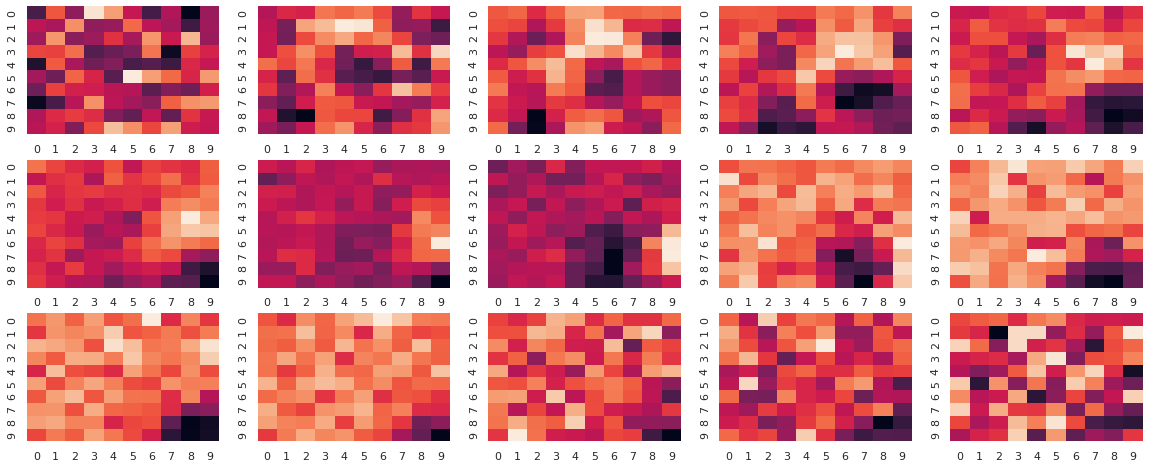

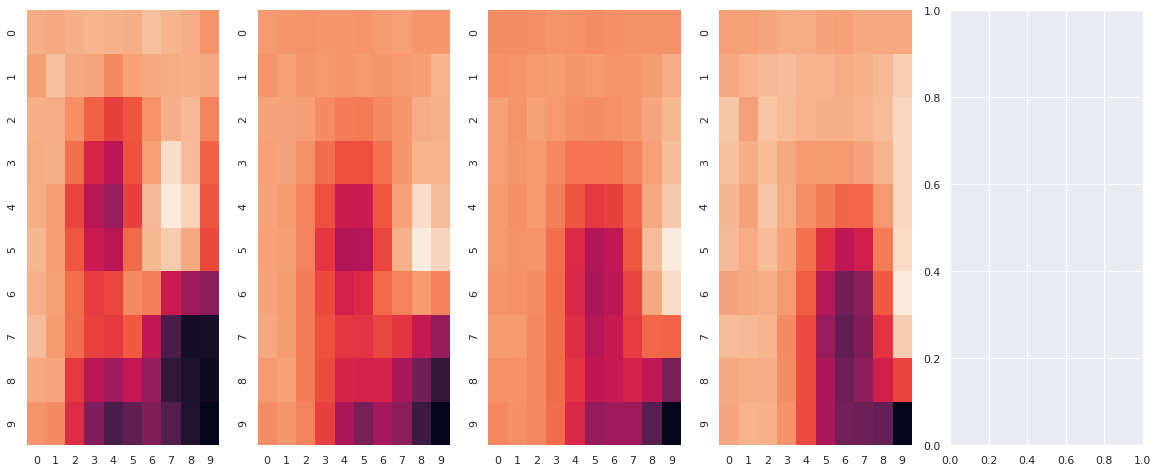

error for the new sample is 0.0013


In [22]:
# simulate data
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
total = 1  # sample one new data point
n = 10
T = 15
theta1 = 0.5
theta2 = 1
theta3 = 1
theta4 = 1
total = 50  # number of test data points
mask = np.ones([total, T]) * np.array([1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1]) == 1
baseline_underlying = np.random.randn(total, n**2)
test_data = DatasetDstm3(n, T, theta1, theta2, theta3, theta4, total, mask, baseline_underlying)
test_data_loader = DataLoader(test_data, 1)  # batch size = 1


# build the model
# encoder pro
rnns = [CLSTM_cell(shape=(10, 10), input_channels=16, filter_size=3, num_features=64,
                   dropout_rate=0),
        CLSTM_cell(shape=(5, 5), input_channels=64, filter_size=5, num_features=96, dropout_rate=0)
        ]

convrelus = [ConvRelu(1, 16, 3, 1, 1, dropout_rate=0.),
             ConvRelu(64, 64, 3, 2, 1, dropout_rate=0.)
             ]

encoder_net = Encoder_pro(rnns, convrelus)

# input for encoder
S = 10
B = 2
input_channels = 1
H = 64
W = 64
input_for_encoder = [torch.randn(B, S, input_channels, H, W)]

# decoder_pro
rnns = [CLSTM_cell(shape=(5, 5), input_channels=1, filter_size=3, num_features=96, dropout_rate=0),
        CLSTM_cell(shape=(10, 10), input_channels=64, filter_size=3, num_features=64, dropout_rate=0)
        ]

deconvrelus = [DeconvRelu(96, 64, 2, 2, 0, dropout_rate=0),
               DeconvRelu(64, 64, 3, 1, 1, dropout_rate=0)
               ]


cnn = ConvCell(in_channels=64, out_channels=1, kernel_size=1, stride=1, padding=0)
decoder_net = Decoder_pro(rnns, deconvrelus, cnn)

# ED net
ED_net = ED_pro(encoder_net, decoder_net)
mc_dropout = 5z`
learning_rate = 1e-4
max_epoch = 20
model = LightningED(ED_net, mc_dropout, learning_rate)

# load from checkpoint
try:
    model.load_from_checkpoint(checkpoint_path='temp.ckpt', ED=ED_net, mc_dropout=mc_dropout, learning_rate=learning_rate)
except:
    print("fail to load the model")
    pass



model.to(device)  # transfer the model to gpu

# predict for one sample
for idx, batch in enumerate(test_data_loader):

    idx, input_for_encoder, input_for_decoder, additional_time_invariant_input, output, seq_len = batch

    input_for_encoder = [i.to(device) for i in input_for_encoder]
    if len(input_for_decoder) != 0:
        input_for_decoder = [i.to(device) for i in input_for_decoder]
    if len(additional_time_invariant_input) != 0:
        additional_time_invariant_input = [i.to(device) for i in additional_time_invariant_input]


    output = model(input_for_encoder, input_for_decoder, additional_time_invariant_input, seq_len)
    
    if idx == 0:
        break

# plot the true data
true_data = test_data.Z[0, ...].squeeze(1)

plot_spatio_temporal_data(true_data)
predicted_data = torch.cat(output, dim=1).cpu().detach().numpy().squeeze(0).squeeze(1)
plot_spatio_temporal_data(predicted_data)

print("error for the new sample is %.4f"%np.mean((predicted_data - true_data[~mask[0, :], ...])**2))